# Unlearn LeNet5 

* **Author** : Yalla Mahanth
* **SR No** : 24004

### imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset

import os
import tqdm
import math
import json
import pickle
import pynvml
import argparse
import numpy as np

# from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime as dt
import matplotlib.gridspec as gridspec


def get_best_gpu(verbose = False):
    pynvml.nvmlInit()
    num_gpus = torch.cuda.device_count()

    if num_gpus == 0:
        if verbose :
            print("[!] No CUDA devices found, running on CPU.")
        return 'cpu'

    gpu_mem = []
    for i in range(num_gpus):
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        free_mem = mem_info.free
        total_mem = mem_info.total
        if verbose:
            print(f"[+] GPU {i}: Total {total_mem / 1e9:.2f} GB, Free {free_mem / 1e9:.2f} GB")
        gpu_mem.append((i, free_mem))

    gpu_mem.sort(key=lambda x: x[1], reverse=True)

    best_gpu = gpu_mem[0][0]
    second_best_gpu = gpu_mem[1][0] if len(gpu_mem) > 1 else best_gpu

    selected_gpu = second_best_gpu if best_gpu == 0 else best_gpu

    pynvml.nvmlShutdown()
    return selected_gpu

def set_gpu(manual_set = None, verbose = False):
    device_active = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device_active == 'cuda':
        if verbose:
            print('[+] CUDA : available')
        try:
            if manual_set is not None:
                GPU_NUMBER = manual_set
            else:
                GPU_NUMBER = get_best_gpu(verbose)
            if verbose:
                print(f'[>] Current Device {torch.cuda.current_device()} -> changing it to {GPU_NUMBER}')
            torch.cuda.set_device(GPU_NUMBER)
            if verbose:
                print(f'[+] Current Device {torch.cuda.current_device()}')
        except Exception as e:
            if verbose:
                print(f'[-] Error Occured while changing GPU ! \n\n\tERROR :{e}\n\n')
                print(f'[!] CUDA ERR : Couldn\'t change  -> using CPU {device_active = }')
        finally: 
            pass
        print(f'[>] device = cuda:{GPU_NUMBER}')
    else :
        if verbose:
            print(f'[!] CUDA ERR : Not available -> using CPU {device_active = }')
        print(f'[>] device = cpu')
set_gpu()

[>] device = cuda:2


## MNIST

In [3]:
mnist_data_folder = './data/MNIST/'
labels = np.arange(10)
mnist_train_images_file =  mnist_data_folder + f'train-images.idx3-ubyte'
mnist_train_labels_file =  mnist_data_folder + f'train-labels.idx1-ubyte'
mnist_test_images_file =  mnist_data_folder + f't10k-images.idx3-ubyte'
mnist_test_labels_file =  mnist_data_folder + f't10k-labels.idx1-ubyte'

# Reading from idx file function code snippet is taken from https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40#file-mnist-py
def read_idx(filename):
    import struct 
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

mnist_train_images = read_idx(mnist_train_images_file)
mnist_train_labels = read_idx(mnist_train_labels_file)
mnist_test_images = read_idx(mnist_test_images_file)
mnist_test_labels = read_idx(mnist_test_labels_file)
mnist_train_images.shape ,mnist_train_labels.shape,mnist_test_images.shape ,mnist_test_labels.shape

def train_test_split(X,y,test_size = 0.2 , shuffle = True):
    if shuffle:
        mask = np.random.permutation(len(y))
        X = X[mask]
        y = y[mask]
    split = len(y) - int(len(y) * test_size)
    return X[:split],y[:split],X[split:],y[split:]

Xtr, ytr, Xval, yval = train_test_split(mnist_train_images, mnist_train_labels, test_size=0.2)
Xte , yte = mnist_test_images, mnist_test_labels

print(f'MNIST DATASET :')
print(f'{Xtr.shape = } , {ytr.shape = }')
print(f'{Xval.shape = } , {yval.shape = }')
print(f'{Xte.shape = } , {yte.shape = }')

Xtr = torch.tensor(Xtr , dtype = torch.float32)
ytr = torch.tensor(ytr , dtype = torch.float32)
Xval = torch.tensor(Xval , dtype = torch.float32)
yval = torch.tensor(yval , dtype = torch.float32)
Xte = torch.tensor(Xte , dtype = torch.float32)
yte = torch.tensor(yte , dtype = torch.float32)

ytr_enc = torch.zeros(ytr.shape[0] , len(labels)) 
yval_enc = torch.zeros(yval.shape[0] , len(labels))
yte_enc = torch.zeros(yte.shape[0] , len(labels))
ytr_enc[torch.arange(ytr.shape[0]) , ytr.long()] = 1
yval_enc[torch.arange(yval.shape[0]) , yval.long()] = 1
yte_enc[torch.arange(yte.shape[0]) , yte.long()] = 1

Xtr = Xtr.view(-1,1,28,28)
Xval = Xval.view(-1,1,28,28)
Xte = Xte.view(-1,1,28,28)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    Xtr = Xtr.cuda()
    Xval = Xval.cuda()
    Xte = Xte.cuda()
    ytr_enc = ytr_enc.cuda()
    yval_enc = yval_enc.cuda()
    yte_enc = yte_enc.cuda()
    ytr = ytr.cuda()
    yval = yval.cuda()
    yte = yte.cuda()    


class DatasetMNIST(Dataset):
    def __init__(self , X , y , labels = labels, device = device):
        # self.X , self.y = self.augmentation(X , y, pixels=2)
        self.X,self.y = X, y
        self.num_classes = len(labels)
        self.labels = np.sort(np.arange(self.num_classes))
        self.device = device
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self , idx):
        pixs = np.random.randint(1,4)
        X_i , y_i = self.random_agumentation(self.X[idx] , self.y[idx] , pixels = pixs)
        y_i = F.one_hot(y_i.long() , num_classes = self.num_classes).float()
        
        if device == 'cuda':
            X_i = X_i.cuda()
            y_i = y_i.cuda()
        
        return X_i , y_i
    
    def random_agumentation(self , X_i , y_i , pixels = 1):
        type = np.random.randint(1,2 * 8 + 1) # half of the time : original
        if type == 1:
            X_Right_shifted = torch.roll(X_i , shifts = pixels , dims = 1)
            X_shifted = X_Right_shifted
        elif type == 2:
            X_Left_shifted = torch.roll(X_i , shifts = -pixels , dims = 1)
            X_shifted = X_Left_shifted
        elif type == 3:
            X_Up_shifted = torch.roll(X_i , shifts = pixels , dims = 0)
            X_shifted = X_Up_shifted
        elif type == 4:
            X_Down_shifted = torch.roll(X_i , shifts = -pixels , dims = 0)
            X_shifted = X_Down_shifted
        elif type == 5:
            X_Right_shifted = torch.roll(X_i , shifts = pixels , dims = 1)
            X_shifted = torch.roll(X_Right_shifted , shifts = pixels , dims = 0)
        elif type == 6:
            X_Left_shifted = torch.roll(X_i , shifts = -pixels , dims = 1)
            X_shifted = torch.roll(X_Left_shifted , shifts = -pixels , dims = 0)
        elif type == 7:
            X_Up_shifted = torch.roll(X_i , shifts = pixels , dims = 0)
            X_shifted = torch.roll(X_Up_shifted , shifts = -pixels , dims = 1)
        elif type == 8:
            X_Down_shifted = torch.roll(X_i , shifts = -pixels , dims = 0)
            X_shifted = torch.roll(X_Down_shifted , shifts = pixels , dims = 1)
        else:
            X_shifted = X_i
        
        return X_shifted , y_i
    

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

MNIST DATASET :
Xtr.shape = (48000, 28, 28) , ytr.shape = (48000,)
Xval.shape = (12000, 28, 28) , yval.shape = (12000,)
Xte.shape = (10000, 28, 28) , yte.shape = (10000,)


## LeNet5

In [4]:
class LeNet5(nn.Module):
    
    def __init__(self, inp_size = 1, filters = (6 , 16), f_sizes = (5,5) , num_classes = 10):
        super(LeNet5,self).__init__()
        
        self.conv1 = nn.Conv2d(inp_size, filters[0], kernel_size = f_sizes[0], stride = 1, padding = 2)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv2 = nn.Conv2d(filters[0], filters[1], kernel_size = f_sizes[1], stride = 1, padding = 0)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(filters[1]*f_sizes[1]*f_sizes[1], 120 , bias = True )
        self.fc2 = nn.Linear(120, 84 , bias = True )
        self.fc3 = nn.Linear(84, num_classes, bias = True )
        
    def forward(self, x):        
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = self.flatten(x)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x    

    
    def predict_proba(self, x):
        x = self.forward(x)
        return F.softmax(x, dim = -1)

    def predict(self, x):
        x = self.predict_proba(x)
        return torch.argmax(x, dim = -1)
    
    def accuracy(self, x, y):
        y_pred = self.predict(x)
        return (y_pred == y).float().mean()


net_params = {
    'inp_size': 1,
    'filters': (6, 16),
    'f_sizes': (5, 5),
    'num_classes': len(labels)
}

model = LeNet5(**net_params)
model


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Evaluator

In [5]:
class Evaluator:
    """ Class to handle all the logic concerning the evaluation of trained models.  """
    def __init__(self, device):
        self.device = device

    @staticmethod
    def accuracy(y_true, y_pred):
        """ Computes the accuracy of the predictions, against a reference set of predictions. """
        return sum(yi_true == yi_pred for yi_true, yi_pred in zip(y_true, y_pred)) / len(y_pred)

    
    def evaluate(self, model_path, data, reference_outputs):
        """ Performs the evaluation of a specified model over given data. """
        model = torch.load(os.path.join(model_path, 'model.pt'), map_location=self.device, weights_only=False)
        model.to(self.device)
        model.eval()
        
        generated_outputs = model.predict(data)
        accuracy_score = self.accuracy(reference_outputs, generated_outputs)

        print("[E] EVALUATION:", ">", "accuracy:", f"{accuracy_score:.2%}")
        print()
    
    def evaluate_model(self, model, data, reference_outputs):
        """ Performs the evaluation of a specified model over given data. """
        model.to(self.device)
        model.eval()
        
        generated_outputs = model.predict(data)
        accuracy_score = self.accuracy(reference_outputs, generated_outputs)

        print("[E] EVALUATION:", ">", "accuracy:", f"{accuracy_score:.2%}")
        print()
    
evaluator = Evaluator(device)
evaluator.evaluate_model(model, Xte, yte)

[E] EVALUATION: > accuracy: 8.75%



## LeNet5 - PreTrained

In [6]:
net_name = 'LeNet5'
version_name = 'v1_test'
directory = f'./models/{net_name}_{version_name}'

if checkpoints := os.listdir(directory):
    last_checkpoint = max(map(lambda x: int(x[11:]), filter(lambda x: 'checkpoint-' in x, checkpoints)))
    checkpoint_dir = os.path.join(directory, f"checkpoint-{last_checkpoint}")
    print(f'[>] loadin {checkpoint_dir}')
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "model.pt"),map_location=device))
    model.to(device)

[>] loadin ./models/LeNet5_v1_test/checkpoint-18750


<All keys matched successfully>

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
evaluator.evaluate_model(model, Xte, yte)

[E] EVALUATION: > accuracy: 99.07%



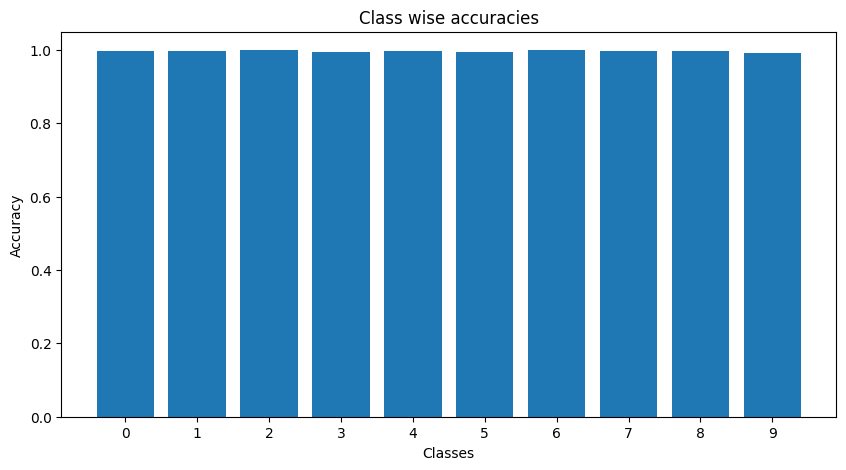

In [ ]:
def get_classs_wise_accuracies(model, Xtr, ytr):
    accs = {}
    for i in list(ytr.unique()):
        cls = int(i.item())
        mask = ytr == cls 
        X_cls = Xtr[mask]
        y_cls = ytr[mask]
        acc = model.accuracy(X_cls, y_cls)
        accs[cls] = acc.item()
    return accs

def plot_class_wise_accuracies(accs):
    plt.figure(figsize = (10,5))
    plt.bar(accs.keys(), accs.values())
    plt.xlabel('Classes')
    plt.ylabel('Accuracy')
    plt.title('Class wise accuracies')
    plt.xticks(list(accs.keys()))
    plt.show()


plot_class_wise_accuracies(get_classs_wise_accuracies(model, Xtr, ytr))

## get responsive layer

In [9]:
def record_layer_io_shapes(model, input_shape=(1, 1, 28, 28), device='cuda'):
    """
    Records input/output shapes of all modules during a dummy forward pass.
    
    Returns a dict: layer_name -> {'input': shape, 'output': shape}
    """
    io_shapes = {}
    hooks = []

    def make_hook(name):
        def hook(module, input, output):
            io_shapes[name] = {
                'input': tuple(input[0].shape),
                'output': tuple(output.shape)
            }
        return hook

    model.eval().to(device)

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Module):
            hooks.append(module.register_forward_hook(make_hook(name)))

    dummy_input = torch.randn(*input_shape).to(device)
    with torch.no_grad():
        model(dummy_input)

    for h in hooks:
        h.remove()
    return io_shapes

layer_sizes = record_layer_io_shapes(model)
layer_sizes

{'conv1': {'input': (1, 1, 28, 28), 'output': (1, 6, 28, 28)},
 'pool1': {'input': (1, 6, 28, 28), 'output': (1, 6, 14, 14)},
 'conv2': {'input': (1, 6, 14, 14), 'output': (1, 16, 10, 10)},
 'pool2': {'input': (1, 16, 10, 10), 'output': (1, 16, 5, 5)},
 'flatten': {'input': (1, 16, 5, 5), 'output': (1, 400)},
 'fc1': {'input': (1, 400), 'output': (1, 120)},
 'fc2': {'input': (1, 120), 'output': (1, 84)},
 'fc3': {'input': (1, 84), 'output': (1, 10)},
 '': {'input': (1, 1, 28, 28), 'output': (1, 10)}}

In [10]:
def generate_class_impression_from_activation(model, target_class, layer_name, init_mode='kaiming', num_steps=300, lr=0.1, device='cuda', verbose = False):
    model.eval().to(device)

    io_shapes = record_layer_io_shapes(model, device=device)
    if layer_name not in io_shapes:
        raise ValueError(f"Layer '{layer_name}' not found.")

    activation_shape = io_shapes[layer_name]['input']
    if verbose:
        print(f"[+] Shape of activation at input to '{layer_name}': {activation_shape}")

    act_tensor = torch.empty(activation_shape, requires_grad=True, device=device)
    if init_mode == 'kaiming':
        torch.nn.init.kaiming_normal_(act_tensor)
    elif init_mode == 'xavier':
        torch.nn.init.xavier_normal_(act_tensor)
    elif init_mode == 'normal':
        torch.nn.init.normal_(act_tensor, mean=0.0, std=0.02)
    else:
        raise ValueError(f"Unsupported init mode: {init_mode}")

    optimizer = torch.optim.Adam([act_tensor], lr=lr)

    found = False
    tail_layers = []
    for name, module in model.named_modules():
        if name == layer_name:
            found = True
        if found and isinstance(module, torch.nn.Module) and name != '':
            tail_layers.append(module)
    if not tail_layers:
        raise RuntimeError(f"No layers found after {layer_name} to build tail model.")

    tail_net = torch.nn.Sequential(*tail_layers).to(device)


    for step in range(num_steps):
        optimizer.zero_grad()
        output = tail_net(act_tensor)
        target_score = output[0, target_class]
        loss = -target_score
        loss.backward()
        optimizer.step()

        if step % 50 == 0 and verbose:
            print(f"[{step:03d}] Class {target_class} score: {target_score.item():.4f}")

    final_scores = tail_net(act_tensor)
    softmaxes = F.softmax(final_scores, dim=-1)
    max_ele = torch.argmax(softmaxes)
    if verbose :
        print(f'{softmaxes = }\n{max_ele = }')
    
    return act_tensor.detach(), activation_shape , max_ele.item()


layer_names = list(layer_sizes.keys())[:-1]
TARGET_CLS = 6

for layer in layer_names:
    activation, shape, max_ele = generate_class_impression_from_activation( 
        model, 
        target_class=TARGET_CLS, 
        layer_name=layer, 
        init_mode='xavier', 
        num_steps= 1000,
        verbose=False
    )
    print(f'{layer = } {max_ele = }')


layer = 'conv1' max_ele = 0
layer = 'pool1' max_ele = 0
layer = 'conv2' max_ele = 0
layer = 'pool2' max_ele = 0
layer = 'flatten' max_ele = 0
layer = 'fc1' max_ele = 0
layer = 'fc2' max_ele = 0
layer = 'fc3' max_ele = 6


In [11]:
target_class = 7
n_attempts = 10
threshold = 8/10
first_responsive_layer = None

all_responses = {}
responsive_layers = []
for layer in layer_names:
    correct = 0
    for _ in range(n_attempts):
        _, _, max_ele = generate_class_impression_from_activation(model, target_class, layer)
        if max_ele == target_class:
            correct += 1
    if correct >= threshold:
        if first_responsive_layer is None:
            first_responsive_layer = layer
        responsive_layers.append(layer)
        
    all_responses[layer] = correct

all_responses, responsive_layers, first_responsive_layer

({'conv1': 0,
  'pool1': 10,
  'conv2': 10,
  'pool2': 10,
  'flatten': 10,
  'fc1': 10,
  'fc2': 10,
  'fc3': 10},
 ['pool1', 'conv2', 'pool2', 'flatten', 'fc1', 'fc2', 'fc3'],
 'pool1')

In [ ]:
def get_learnable_layers(model, responsive_layers):
    learnable_layers = []

    # For each responsive layer name
    for layer_name in responsive_layers:
        has_params = False
        for name, param in model.named_parameters():
            if layer_name in name and param.requires_grad and param.numel() > 0:
                has_params = True
                break
        if has_params:
            learnable_layers.append(layer_name)
        else:
            print(f"⏭ Skipping non-learnable layer: {layer_name}")
    
    return learnable_layers

learnable_layers = get_learnable_layers(model, responsive_layers)
learnable_layers

⏭️ Skipping non-learnable layer: pool1
⏭️ Skipping non-learnable layer: pool2
⏭️ Skipping non-learnable layer: flatten


['conv2', 'fc1', 'fc2', 'fc3']

In [13]:
first_responsive_layer = learnable_layers[-1]
first_responsive_layer

'fc3'

## Generate Class Impressions

In [14]:
print(f'path : {directory}/class_impressions/')
os.makedirs(f'{directory}/class_impressions/',exist_ok=True)

path : ./models/LeNet5_v1_test/class_impressions/


In [15]:
def generate_class_impression_dataset(model, target_class, layer_name,  num_samples=500, init_mode='kaiming', num_steps=300, lr=0.1, device='cuda'):
    all_activations = []
    eps = 1e-9
    while len(all_activations) < num_samples:
        impression, shape, max_ele = generate_class_impression_from_activation(model, target_class=target_class, layer_name=layer_name, init_mode=init_mode, num_steps=num_steps, lr=lr, device = device)
        if max_ele == target_class:
            for s in all_activations:
                if torch.norm(s - impression) < eps:
                    break
            else:
                all_activations.append(impression)

    stacked_tensor = torch.cat(all_activations, dim=0)
    save_path = f'{directory}/class_impressions/{layer_name}_class_{target_class}_{num_samples}.pt'
    torch.save(stacked_tensor, save_path)
    
    return save_path

In [ ]:

TARGET_CLS = 6
NUM_SAMPLES = 100
LAYER_FROM = first_responsive_layer
INIT_MODE = 'xavier'
STEPS_PER_SAMPLE = 1000
LEARN_RATE = 0.1

# path = generate_class_impression_dataset(
#     model=model,
#     target_class=TARGET_CLS,
#     layer_name=LAYER_FROM,
#     num_samples=NUM_SAMPLES,
#     init_mode=INIT_MODE,
#     num_steps=STEPS_PER_SAMPLE,
#     lr=LEARN_RATE,
#     device=device
# )

# print(f"Saved dataset to {path}")

Saved dataset to ./models/LeNet5_v1_test/class_impressions/fc3_class_6_100.pt


In [17]:
def generate_class_impression(model, target_class, layer_name, directory,  num_samples=500, init_mode='kaiming', num_steps=300, lr=0.1, device='cuda'):
    save_path = f'{directory}/class_impressions/{layer_name}_class_{target_class}_{num_samples}.pt'
    if os.path.exists(save_path):
        print(f"[!] Class impression dataset for class {target_class} and layer {layer_name} already exists.")
        return save_path
    all_activations = []
    eps = 1e-9
    while len(all_activations) < num_samples:
        impression, shape, max_ele = generate_class_impression_from_activation(model, target_class=target_class, layer_name=layer_name, init_mode=init_mode, num_steps=num_steps, lr=lr, device = device)
        if max_ele == target_class:
            for s in all_activations:
                if torch.norm(s - impression) < eps:
                    break
            else:
                all_activations.append(impression)

    stacked_tensor = torch.cat(all_activations, dim=0)
    torch.save(stacked_tensor, save_path)
    
    return save_path

def generate_cis_for_all_classes(labels, model, layer_name, directory, num_samples=500, init_mode='kaiming', num_steps=300, lr=0.1, device='cuda'):
    paths = {}
    for cls in list(labels):    
        paths[cls] = generate_class_impression(
            model=model,
            target_class=cls,
            layer_name=layer_name,
            directory=directory,
            num_samples=num_samples,
            init_mode=init_mode,
            num_steps=num_steps,
            lr=lr,
            device=device 
        )
        print(f'[+] {cls = } {paths[cls] = }')
    return paths 


NUM_SAMPLES = 100
LAYER_NAME = first_responsive_layer
INIT_MODE = 'xavier'
STEPS_PER_SAMPLE = 1000
LEARN_RATE = 0.1

paths_cis = generate_cis_for_all_classes(
    labels = labels,
    model  = model,
    directory = directory,
    layer_name=LAYER_NAME,
    num_samples=NUM_SAMPLES,
    init_mode=INIT_MODE,
    num_steps=STEPS_PER_SAMPLE,
    lr=LEARN_RATE,
    device=device,
)

print(paths_cis)

[!] Class impression dataset for class 0 and layer fc3 already exists.
[+] cls = np.int64(0) paths[cls] = './models/LeNet5_v1_test/class_impressions/fc3_class_0_100.pt'
[!] Class impression dataset for class 1 and layer fc3 already exists.
[+] cls = np.int64(1) paths[cls] = './models/LeNet5_v1_test/class_impressions/fc3_class_1_100.pt'
[!] Class impression dataset for class 2 and layer fc3 already exists.
[+] cls = np.int64(2) paths[cls] = './models/LeNet5_v1_test/class_impressions/fc3_class_2_100.pt'
[!] Class impression dataset for class 3 and layer fc3 already exists.
[+] cls = np.int64(3) paths[cls] = './models/LeNet5_v1_test/class_impressions/fc3_class_3_100.pt'
[!] Class impression dataset for class 4 and layer fc3 already exists.
[+] cls = np.int64(4) paths[cls] = './models/LeNet5_v1_test/class_impressions/fc3_class_4_100.pt'
[!] Class impression dataset for class 5 and layer fc3 already exists.
[+] cls = np.int64(5) paths[cls] = './models/LeNet5_v1_test/class_impressions/fc3_cl

In [18]:
def get_class_impression_paths(directory, layer_name, num_samples):
    imp_folder = f'{directory}/class_impressions/'
    paths_ = os.listdir(imp_folder)
    paths = {}
    for p in paths_:
        k = p.split('_')
        cls = int(k[-2])
        num_samp = int(k[-1].split('.')[0])
        layer = k[0]
        if num_samp == num_samples and layer == layer_name:
            paths[cls] = f'{imp_folder}{p}'
    return paths


directory = f'./models/{net_name}_{version_name}'
layer_name = first_responsive_layer
num_samples = NUM_SAMPLES
paths = get_class_impression_paths(directory, layer_name, num_samples)
print(paths)


{6: './models/LeNet5_v1_test/class_impressions/fc3_class_6_100.pt', 0: './models/LeNet5_v1_test/class_impressions/fc3_class_0_100.pt', 1: './models/LeNet5_v1_test/class_impressions/fc3_class_1_100.pt', 2: './models/LeNet5_v1_test/class_impressions/fc3_class_2_100.pt', 3: './models/LeNet5_v1_test/class_impressions/fc3_class_3_100.pt', 4: './models/LeNet5_v1_test/class_impressions/fc3_class_4_100.pt', 5: './models/LeNet5_v1_test/class_impressions/fc3_class_5_100.pt', 7: './models/LeNet5_v1_test/class_impressions/fc3_class_7_100.pt', 8: './models/LeNet5_v1_test/class_impressions/fc3_class_8_100.pt', 9: './models/LeNet5_v1_test/class_impressions/fc3_class_9_100.pt'}


In [19]:
def get_datasets_from_paths_2(paths, target_classes, labels = labels):
    retain_impressions = []
    retain_y = []
    forget_impressions = []
    forget_y = []
    for i in list(labels):
        cls = int(i.item())
        repeated_cls = torch.ones(NUM_SAMPLES , dtype = torch.long , device = device) * cls
        cls_impressions = torch.load(paths[cls]).to(device)
        if cls in target_classes:
            forget_impressions.append(cls_impressions)
            forget_y.append(repeated_cls)
        else :
            retain_impressions.append(cls_impressions)
            retain_y.append(repeated_cls)
            
    X_forget = torch.cat(forget_impressions)
    X_retain = torch.cat(retain_impressions)
    y_forget = torch.cat(forget_y)
    y_retain = torch.cat(retain_y)

    return X_forget, y_forget, X_retain, y_retain

target_classes = {1,2,3,4}

X_forget, y_forget, X_retain, y_retain = get_datasets_from_paths_2(paths , target_classes)
print(f'{X_forget.shape = }\t{y_forget.shape = }')
print(f'{X_retain.shape = }\t{y_retain.shape = }')

X_forget.shape = torch.Size([400, 84])	y_forget.shape = torch.Size([400])
X_retain.shape = torch.Size([600, 84])	y_retain.shape = torch.Size([600])


In [ ]:
# def filter_out_classes(X, y, target_classes, device = device):
#     if device == 'cuda':
#         X_cpu = X.cpu()
#         y_cpu = y.cpu()    
#     mask = ~torch.isin(y_cpu, torch.tensor(list(target_classes)))
#     X_filtered = X_cpu[mask]
#     y_filtered = y_cpu[mask]
#     if device == 'cuda':
#         X_filtered = X_filtered.cuda()
#         y_filtered = y_filtered.cuda()
#     return X_filtered, y_filtered

# Xte.shape, yte.shape

# X_filtered, y_filtered = filter_out_classes(Xte, yte, target_classes)
# X_filtered.shape, y_filtered.shape

(torch.Size([10000, 1, 28, 28]), torch.Size([10000]))

(torch.Size([5841, 1, 28, 28]), torch.Size([5841]))

## ZeroShotUnlearner

In [ ]:
import copy

class ZeroShotUnlearner:
    def __init__(self, model, forget_loader, retain_loader, first_responsive_layer_string, forget_loss_weight=0.9, retain_loss_weight=0.1, lr=1e-4, device='cuda', clip_grad=5.0): 
        self.device = device
        self.model = model.to(device)
        self.forget_loader = forget_loader
        self.retain_loader = retain_loader
        self.forget_loss_weight = forget_loss_weight
        self.retain_loss_weight = retain_loss_weight
        self.clip_grad = clip_grad

        
        self.tail_model = self._get_tail_model(first_responsive_layer_string).to(device)

        
        self._freeze_before(first_responsive_layer_string)

        
        self.optimizer = optim.AdamW(self.tail_model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    def _get_tail_model(self, layer_string):
        modules = []
        include = False
        for name, module in self.model.named_children():
            if layer_string in name:
                include = True  
            if include:
                modules.append(module)
        if not modules:
            print(f"[-] No layers found after {layer_string} to build tail model.")
            
        return nn.Sequential(*modules)

    def _freeze_before(self, layer_string):
        freeze = True
        for name, param in self.model.named_parameters():
            if freeze:
                param.requires_grad = False
            if layer_string in name:
                freeze = False
        print(f"[+] Frozen layers before and including: {layer_string}")

    def unlearn(self, epochs=10):
        self.model.eval()
        self.tail_model.train()

        for ep in range(epochs):
            total_f_loss, total_r_loss = 0.0, 0.0

            
            for x_f, y_f in self.forget_loader:
                x_f, y_f = x_f.to(self.device), y_f.to(self.device)
                out_f = self.tail_model(x_f)
                loss_f = self.criterion(out_f, y_f)

                
                loss =  self.forget_loss_weight * loss_f

                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.tail_model.parameters(), self.clip_grad)
                self.optimizer.step()

                total_f_loss += loss_f.item()

            
            for x_r, y_r in self.retain_loader:
                x_r, y_r = x_r.to(self.device), y_r.to(self.device)
                out_r = self.tail_model(x_r)
                loss_r = self.criterion(out_r, y_r)

                
                loss = - self.retain_loss_weight * loss_r
                
                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.tail_model.parameters(), self.clip_grad)
                self.optimizer.step()

                total_r_loss += loss_r.item()
            if (ep+1) % 10 == 0:
                print(f"Epoch [{ep+1:5d}/{epochs:5d}] | Forget Loss: {total_f_loss:.6f} | Retain Loss: {total_r_loss:.6f}")

        return self.tail_model



u_model = copy.deepcopy(model)
BATCH_SIZE = 16 

X_forget_dataset = torch.utils.data.TensorDataset(X_forget, y_forget)
X_retain_dataset = torch.utils.data.TensorDataset(X_retain, y_retain)

print(f'{len(X_forget_dataset) = }, {len(X_retain_dataset) = }')
print(f'{first_responsive_layer = }')

unlearner = ZeroShotUnlearner(
    u_model, 
    first_responsive_layer_string= first_responsive_layer,
    forget_loader= torch.utils.data.DataLoader(X_forget_dataset, batch_size=BATCH_SIZE, shuffle=True),
    retain_loader= torch.utils.data.DataLoader(X_retain_dataset, batch_size=BATCH_SIZE, shuffle=True),
    lr = 1e-3,
    forget_loss_weight=0.9, 
    retain_loss_weight=0.1,
)

tail_model = unlearner.unlearn(epochs=1000)

len(X_forget_dataset) = 400, len(X_retain_dataset) = 600
first_responsive_layer = 'fc3'
✅ Frozen layers before and including: fc3


Epoch [   10/ 1000] | Forget Loss: 1078.507465 | Retain Loss: 1653.346642
Epoch [   20/ 1000] | Forget Loss: 1077.336388 | Retain Loss: 1659.154743
Epoch [   30/ 1000] | Forget Loss: 1076.166725 | Retain Loss: 1650.775452
Epoch [   40/ 1000] | Forget Loss: 1075.003418 | Retain Loss: 1655.847187
Epoch [   50/ 1000] | Forget Loss: 1073.846992 | Retain Loss: 1661.610748
Epoch [   60/ 1000] | Forget Loss: 1072.693169 | Retain Loss: 1659.087727
Epoch [   70/ 1000] | Forget Loss: 1071.545578 | Retain Loss: 1659.874516
Epoch [   80/ 1000] | Forget Loss: 1070.406708 | Retain Loss: 1658.003387
Epoch [   90/ 1000] | Forget Loss: 1069.277805 | Retain Loss: 1660.225243
Epoch [  100/ 1000] | Forget Loss: 1068.157310 | Retain Loss: 1667.323055
Epoch [  110/ 1000] | Forget Loss: 1067.040939 | Retain Loss: 1667.970058
Epoch [  120/ 1000] | Forget Loss: 1065.930801 | Retain Loss: 1664.867962
Epoch [  130/ 1000] | Forget Loss: 1064.828018 | Retain Loss: 1665.898727
Epoch [  140/ 1000] | Forget Loss: 106

In [20]:
def split_dataset_based_on_classes(X,y, classes, device = device):
    if device == 'cuda':
        X_cpu = X.cpu()
        y_cpu = y.cpu()
    mask = torch.isin(y_cpu, torch.tensor(list(target_classes)))
    X_with = X_cpu[mask]
    y_with = y_cpu[mask]
    X_without = X_cpu[~mask]
    y_without = y_cpu[~mask]
    if device == 'cuda':
        X_with = X_with.cuda()
        y_with = y_with.cuda()
        X_without = X_without.cuda()
        y_without = y_without.cuda()
        
    return X_with, y_with, X_without, y_without
    
X_with, y_with, X_without, y_without = split_dataset_based_on_classes(Xte, yte, target_classes)
X_with.shape, y_with.shape, X_without.shape, y_without.shape

(torch.Size([4159, 1, 28, 28]),
 torch.Size([4159]),
 torch.Size([5841, 1, 28, 28]),
 torch.Size([5841]))

## Result - plots

In [ ]:
def plot_compare_class_wise_accuracies(accs1, accs2, text = ''):
    plt.figure(figsize = (10,5))
    plt.bar(np.array(list(accs1.keys())) - 0.2, accs1.values(), width = 0.4, label = 'Original Model')
    plt.bar(np.array(list(accs2.keys())) + 0.2, accs2.values(), width = 0.4, label = 'Unlearned Model')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy')
    plt.title(f'Class wise accuracies {text}')
    plt.legend()
    plt.xticks(list(accs1.keys()))
    plt.show()

[E] EVALUATION: > accuracy: 99.07%

[E] EVALUATION: > accuracy: 0.00%

[E] EVALUATION: > accuracy: 99.44%

[E] EVALUATION: > accuracy: 58.08%



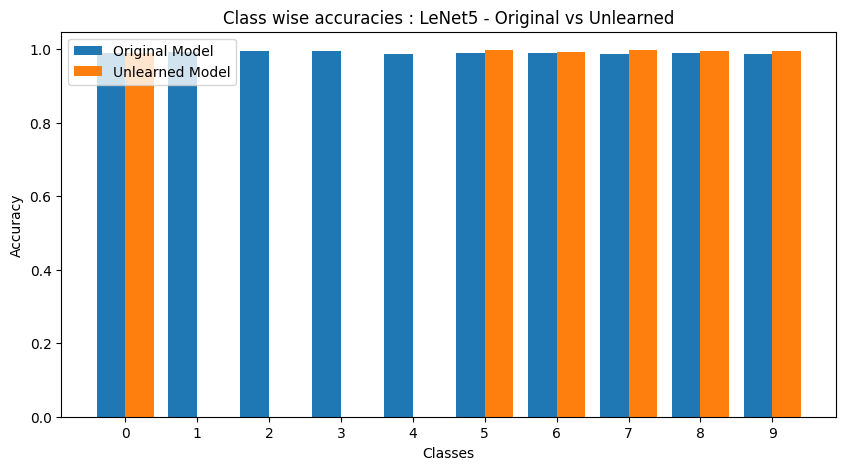

In [26]:
evaluator.evaluate_model(model,Xte, yte)

evaluator.evaluate_model(u_model, X_with, y_with)
evaluator.evaluate_model(u_model, X_without, y_without)
evaluator.evaluate_model(u_model, Xte, yte)

acc1 = get_classs_wise_accuracies(model, Xte, yte)
acc2 = get_classs_wise_accuracies(u_model, Xte, yte)
plot_compare_class_wise_accuracies(acc1 , acc2, ': LeNet5 - Original vs Unlearned')